In [5]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import japanize_matplotlib
from glob import glob
from pathlib import Path
from tqdm import tqdm
import shutil
from consts import DATASET_ROOT, DATASET_PARENT_ROOT, CHECKPOINTS_ROOT
from utils import (
    Range,
    ColorRange,
    filter_blue,
    focus_yellow,
    to_pil,
    run_focusing_yellow,
    COLOR_RANGE,
    draw_from_binary_mask,
    draw_bbox,
    get_weak_reflection_parts,
    combine_images,
)

In [6]:
def display_images(original, reflection, mask, non_reflective):
    fig, axes = plt.subplots(1, 4, figsize=(20, 10))

    axes[0].imshow(original)
    axes[0].set_title("オリジナル画像")
    axes[0].axis("off")

    axes[1].imshow(reflection, cmap="gray")
    axes[1].set_title("光の反射を除去 (RefRemovalモデルの出力)")
    axes[1].axis("off")

    axes[2].imshow(mask, cmap="gray")
    axes[2].set_title("光の反射が強い部分を閾値で絞ってマスク化")
    axes[2].axis("off")

    axes[3].imshow(non_reflective)
    axes[3].set_title("光の反射が強い部分を除去した画像\n (bboxはGTから余白を付けて描画)")
    axes[3].axis("off")

    # plt.savefig(f"{STEM}.png", bbox_inches="tight")
    plt.tight_layout()
    plt.show()


def convert_to_binary_mask(image, threshold=127):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    binary_mask = np.where(binary_mask == 255, 0, 255).astype(np.uint8)
    return binary_mask


def filter_large_components(mask, min_size=100):
    # ラベル付けと統計情報の取得
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=4)

    # 大きな連結成分のみを残すためのマスクを作成
    large_components_mask = np.zeros_like(mask)

    left_label_mask_is = []
    for i in range(1, num_labels):  # ラベル0は背景
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            large_components_mask[labels == i] = 255
            left_label_mask_is.append(i)

    left_label_masks = [labels == i for i in left_label_mask_is]
    return large_components_mask, left_label_masks

def draw_obj_bbox(_image:np.ndarray, obj_mask:np.ndarray, M = 10):
    x, y, w, h = cv2.boundingRect(obj_mask)
    x, y, w, h = x - M, y - M, w + 2 * M, h + 2 * M
    _image = draw_bbox(_image, x, y, w, h, color=(0, 0, 255), thickness=2)
    return _image


In [7]:
stems = [Path(p).stem for p in glob(f"{DATASET_ROOT}/comp/*.png")]
MASK_ROOT = f"{DATASET_PARENT_ROOT}/label_studio/VID_20240124_163346/mask"

STEM = stems[1]

ROOT = f"{CHECKPOINTS_ROOT}/dsrnet_s_test/20240603-165422/test/{STEM}"
# origin_image = f"comp/{STEM}.png"
origin_image_p = f"{ROOT}/m_input.png"
dsrnet_s_test_l_p = f"{ROOT}/dsrnet_s_test_l.png"
dsrnet_s_test_r_p = f"{ROOT}/dsrnet_s_test_r.png"
dsrnet_s_test_rr_p = f"{ROOT}/dsrnet_s_test_rr.png"

assert np.all([os.path.exists(p) for p in [origin_image_p, dsrnet_s_test_l_p, dsrnet_s_test_r_p, dsrnet_s_test_rr_p]])


obj_masks = {s: cv2.imread(os.path.join(MASK_ROOT, f"{s}.png")) for s in stems}
obj_masks = {k: cv2.cvtColor(v, cv2.COLOR_BGR2GRAY) for k, v in obj_masks.items()}
origin_image = cv2.imread(origin_image_p)
obj_masks = {k: cv2.resize(v, (origin_image.shape[1], origin_image.shape[0])) for k, v in obj_masks.items()}

# 反射が弱い箇所のみを残した


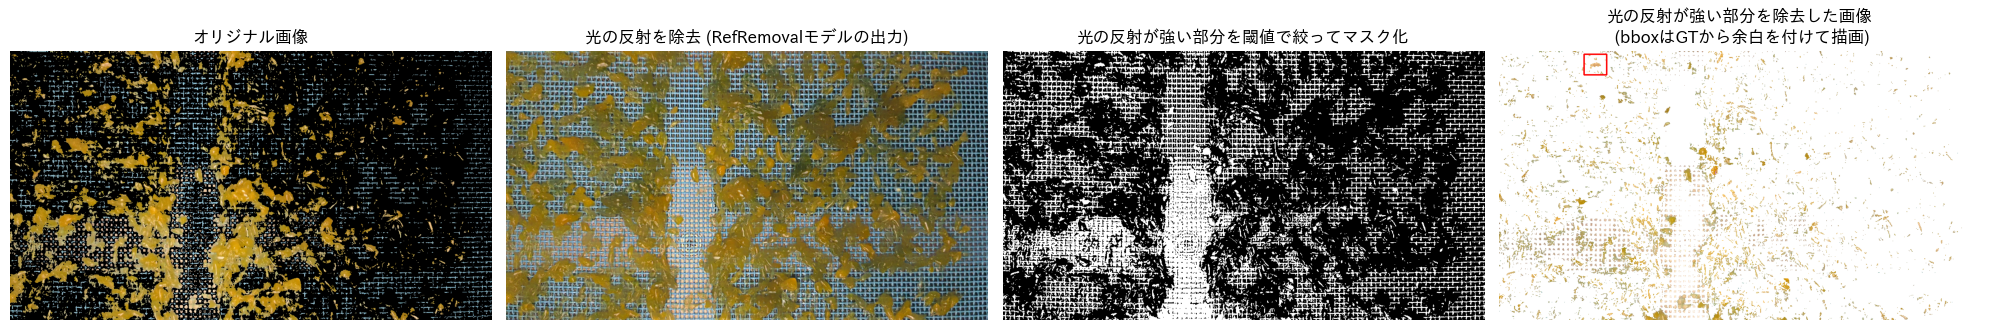

In [8]:
origin_image, dsrnet_s_test_l, mask, masked = get_weak_reflection_parts(
    origin_image_p, dsrnet_s_test_l_p, dsrnet_s_test_r_p, dsrnet_s_test_rr_p, obj_masks[STEM], does_draw_bbox=True
)
before = masked[:, :, ::-1].copy()

display_images(
    origin_image[:, :, ::-1],
    dsrnet_s_test_l[:, :, ::-1],
    mask,
    masked[:, :, ::-1],
)

# ある程度の大きさの領域のみを残した画像


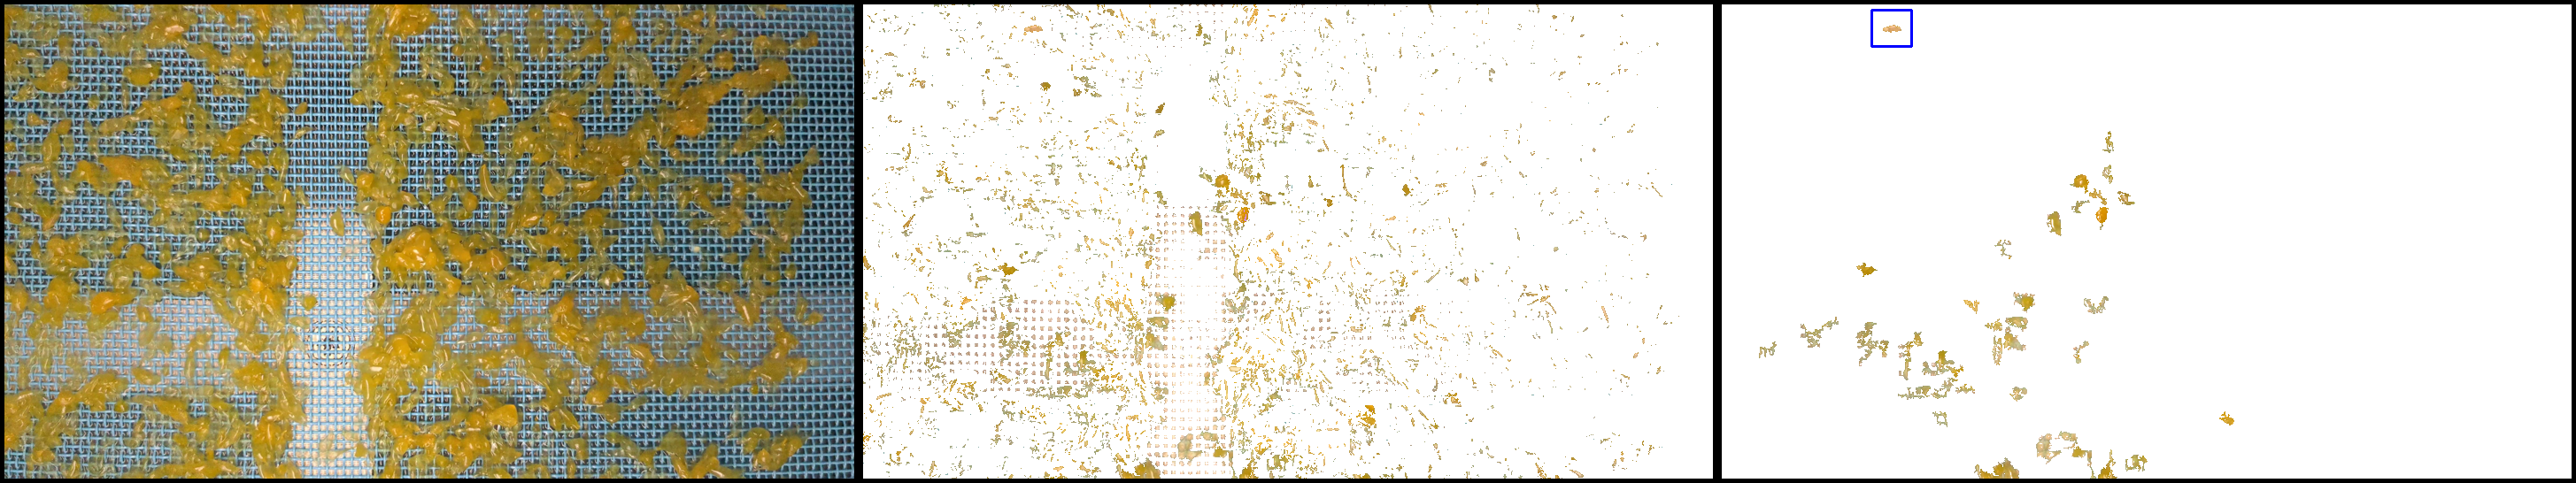

In [9]:
origin_image, dsrnet_s_test_l, mask, masked = get_weak_reflection_parts(
    origin_image_p, dsrnet_s_test_l_p, dsrnet_s_test_r_p, dsrnet_s_test_rr_p, obj_masks[STEM], does_draw_bbox=False
)

before = masked[:, :, ::-1].copy()

mask = convert_to_binary_mask(before, threshold=196)
mask, left_label_masks = filter_large_components(mask)

origin = np.array(Image.open(origin_image_p))
after = cv2.bitwise_and(origin, origin, mask=mask)
after = np.where(mask[:, :, None] == 0, 255, after).astype(np.uint8)

large_mask_mask = mask.copy()
large_mask_image = after.copy()

after = draw_obj_bbox(after, obj_masks[STEM])
combine_images([origin, before, after], rtn_pil=True)


# 更に DSRNet の特性から、他の領域までの距離が大きい領域のみを残して異物を絞ろうとした画像


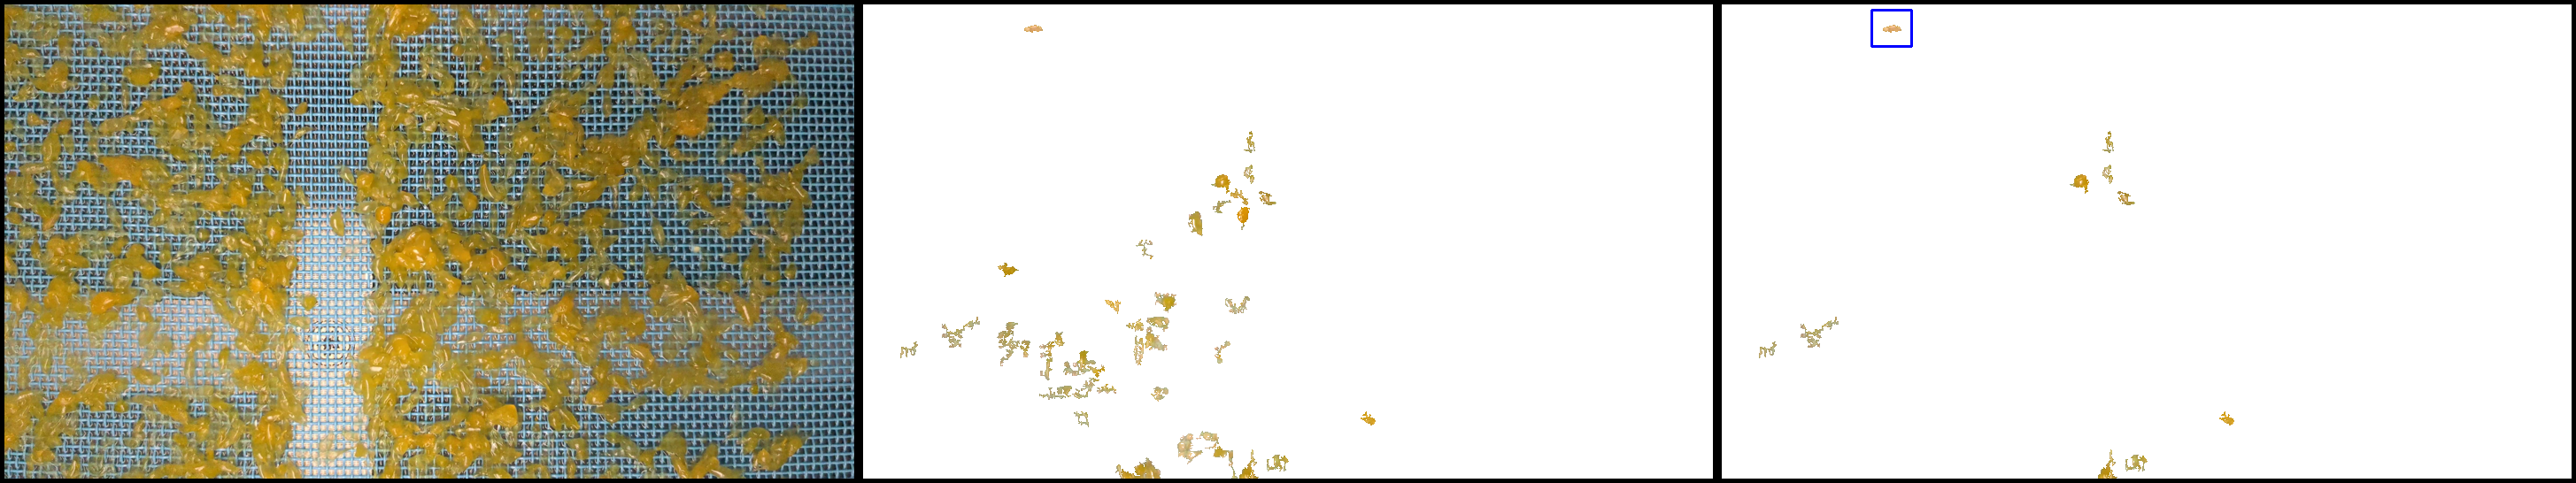

In [10]:
mask = large_mask_mask.copy()
after = large_mask_image.copy()

# -----------------------------------------------
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
label_masks = np.array([np.where(labels == i, 255, 0).astype(np.uint8) for i in range(1, num_labels)])

# ラベルの重心（centroids）を取得
centroids = centroids[1:]  # ラベル0（背景）を除外

# 距離行列を計算
dist_matrix = np.linalg.norm(centroids[:, np.newaxis] - centroids, axis=2)

# 他のすべてのラベルとの最小距離を計算
min_distances = np.min(dist_matrix + np.eye(dist_matrix.shape[0]) * np.max(dist_matrix), axis=1)
avg_distances = np.mean(dist_matrix + np.eye(dist_matrix.shape[0]) * np.max(dist_matrix), axis=1)

sorted_label_masks = label_masks[np.argsort(avg_distances)[::-1]]

# far_is = [i for i,dist in enumerate(avg_distances) if dist >= 300]
# far_is = sorted(far_is, key=lambda i: avg_distances[i], reverse=True)
far_is = sorted(list(range(len(avg_distances))), key=lambda i: avg_distances[i], reverse=True)
far_is = far_is[:10]

# for min_dist, avg_dist, msk in zip(min_distances, avg_distances, label_masks):
far_mask = np.zeros_like(mask)
for min_dist, avg_dist, msk in zip(min_distances[far_is], avg_distances[far_is], label_masks[far_is]):
    far_mask += msk

image = cv2.bitwise_and(origin, origin, mask=far_mask)
image = np.where(far_mask[:, :, None] == 0, 255, image).astype(np.uint8)
image = draw_obj_bbox(image, obj_masks[STEM])

combine_images([origin, after, image], rtn_pil=True)


# 異物箇所とその他とで色味の違いはあるか？


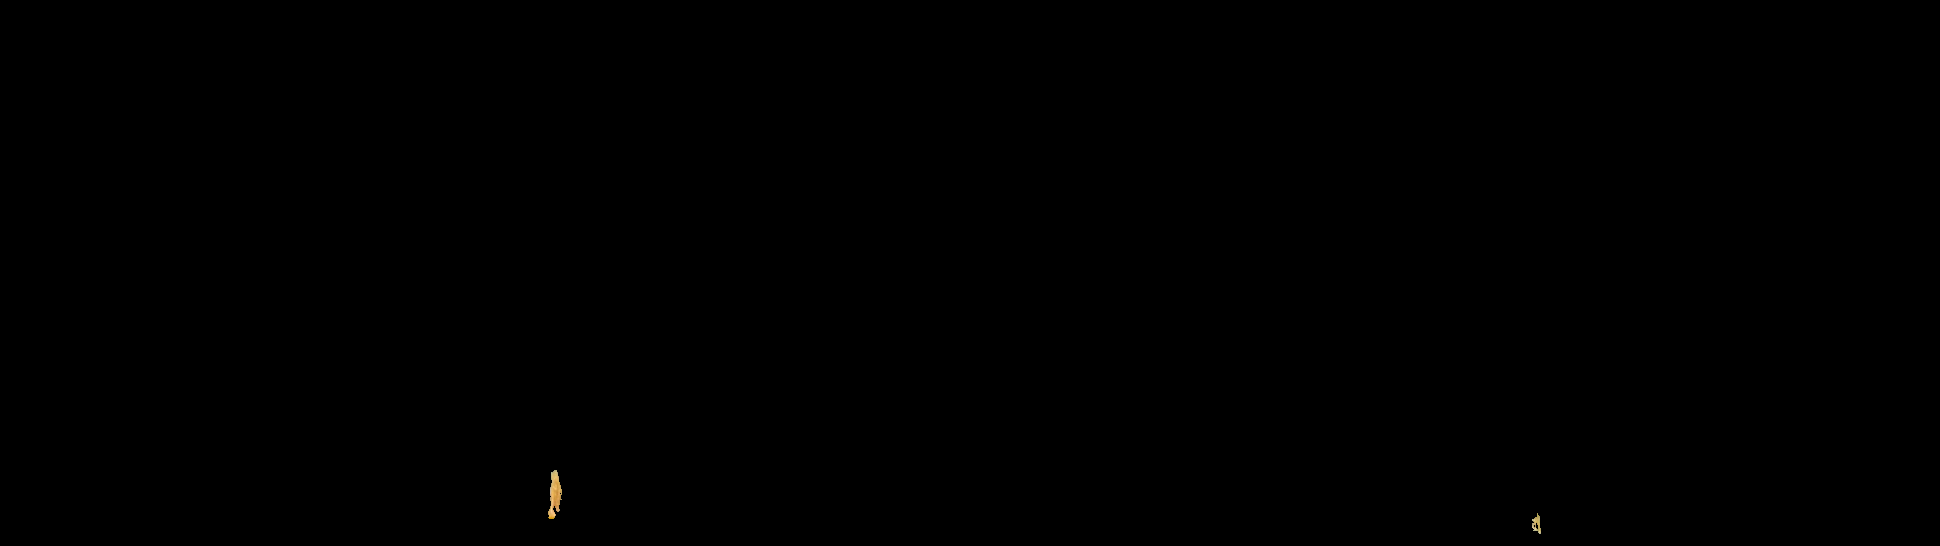

In [11]:
all_bad_patches, all_good_patches = [], []

# OUT_ROOT = 'datasets/large_mask_images'
# f'{DATASET_PARENT_ROOT}/extracted_frames/VID_20240124_153649--1s/good/*'
# shutil.rmtree(OUT_ROOT, ignore_errors=True)
# os.makedirs(f'{OUT_ROOT}/good', exist_ok=True)
# os.makedirs(f'{OUT_ROOT}/bad', exist_ok=True)
# os.makedirs(f'{OUT_ROOT}/mask', exist_ok=True)

for STEM in stems:
    ROOT = f"{CHECKPOINTS_ROOT}/dsrnet_s_test/20240603-165422/test/{STEM}"
    origin_image_p = f"{ROOT}/m_input.png"
    dsrnet_s_test_l_p = f"{ROOT}/dsrnet_s_test_l.png"
    dsrnet_s_test_r_p = f"{ROOT}/dsrnet_s_test_r.png"
    dsrnet_s_test_rr_p = f"{ROOT}/dsrnet_s_test_rr.png"
    
    origin_image, dsrnet_s_test_l, mask, masked = get_weak_reflection_parts(
        origin_image_p, dsrnet_s_test_l_p, dsrnet_s_test_r_p, dsrnet_s_test_rr_p, obj_masks[STEM], does_draw_bbox=False
    )

    before = masked[:, :, ::-1].copy()

    mask = convert_to_binary_mask(before, threshold=196)
    mask, left_label_masks = filter_large_components(mask)

    origin = np.array(Image.open(origin_image_p))
    after = cv2.bitwise_and(origin, origin, mask=mask)
    after = np.where(mask[:, :, None] == 0, 255, after).astype(np.uint8)

    for i, left_mask in enumerate(left_label_masks):
        left_mask = left_mask.astype(np.uint8) * 255
        patch = cv2.bitwise_and(origin, origin, mask=left_mask)

        q = cv2.bitwise_and(left_mask, left_mask, mask=obj_masks[STEM])
        if np.sum(q) == 0:
            all_good_patches.append(patch)
        else:
            all_bad_patches.append(patch)
            # Image.fromarray(left_mask).save(f'{OUT_ROOT}/mask/{STEM}_{i}.png')
    # Image.fromarray(after).save(f'{OUT_ROOT}/bad/{STEM}.png')

combine_images(all_bad_patches[:2], W=2, rtn_pil=True)

100%|██████████| 18/18 [00:00<00:00, 72.79it/s]


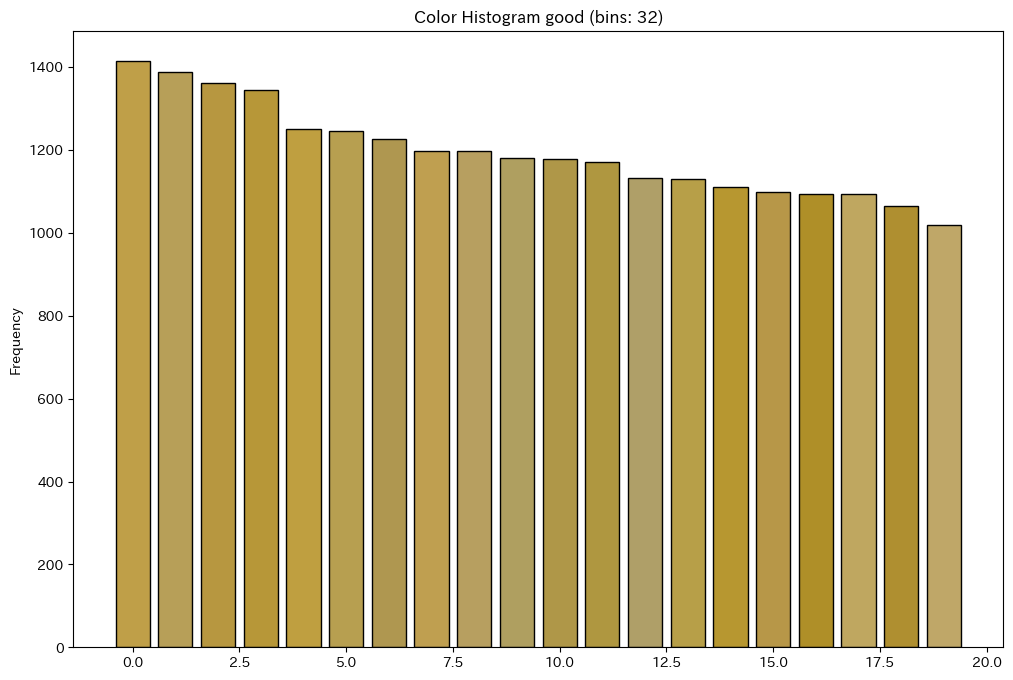

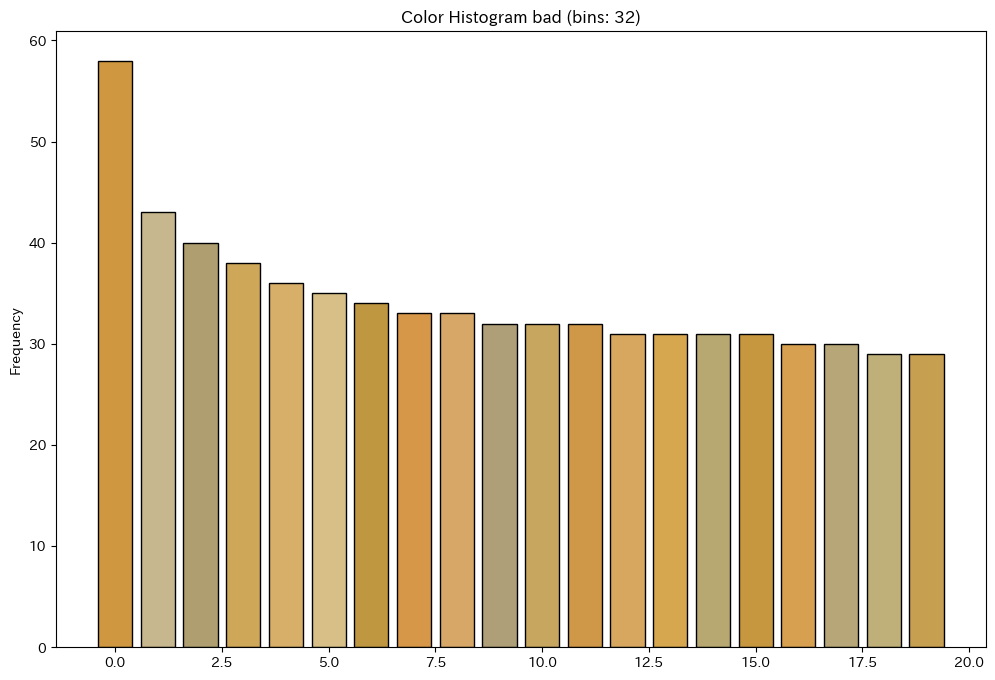

In [15]:
# -----------------------------------------------
# RGB
# -----------------------------------------------


import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def quantize_colors(image, bins):
    bin_width = 256 // bins
    quantized_image = (image // bin_width) * bin_width + bin_width // 2
    return quantized_image

def calculate_color_histogram(images, bins):
    bin_width = 256 // bins
    hist = np.zeros((bins, bins, bins))
    for img in tqdm(images):
        # Exclude black pixels
        mask = np.all(img == [0, 0, 0], axis=-1)
        non_black_pixels = img[~mask]
        
        quantized_image = quantize_colors(non_black_pixels, bins)
        r = quantized_image[..., 0] // bin_width
        g = quantized_image[..., 1] // bin_width
        b = quantized_image[..., 2] // bin_width
        for ri, gi, bi in zip(r, g, b):
            hist[ri, gi, bi] += 1
    return hist

def plot_color_histogram(hist, bins, name='good', num_colors=20):
    hist_flat = hist.flatten()
    colors = np.array([[r, g, b] for r in range(bins) for g in range(bins) for b in range(bins)])
    
    # Normalize histogram
    # hist_flat = hist_flat / hist_flat.sum()
    
    # Sort by frequency
    sorted_indices = np.argsort(hist_flat)[::-1]
    hist_flat = hist_flat[sorted_indices]
    colors = colors[sorted_indices]
    
    # Plot the histogram
    plt.figure(figsize=(12, 8))
    for i in range(min(len(hist_flat), num_colors)):  # Only show top num_colors
        plt.bar(i, hist_flat[i], color=colors[i] / bins, edgecolor='black')
    
    plt.title(f'Color Histogram {name} (bins: {bins})')
    # plt.xlabel('Color Index')
    # plt.ylabel('Normalized Frequency')
    plt.ylabel('Frequency')
    # plt.xticks(range(min(len(hist_flat), num_colors)), labels=range(1, min(len(hist_flat), num_colors) + 1))

    plt.savefig(f"color_histogram_{name}_bins{bins}.png", bbox_inches="tight")
    plt.show()

# Calculate color histograms
bins = 32  # Number of bins for each color channel
color_histogram_good = calculate_color_histogram(all_good_patches, bins)
color_histogram_bad = calculate_color_histogram(all_bad_patches, bins)

# Plot color histograms
plot_color_histogram(color_histogram_good, bins, name='good')
plot_color_histogram(color_histogram_bad, bins, name='bad')


100%|██████████| 18/18 [00:00<00:00, 911.60it/s]


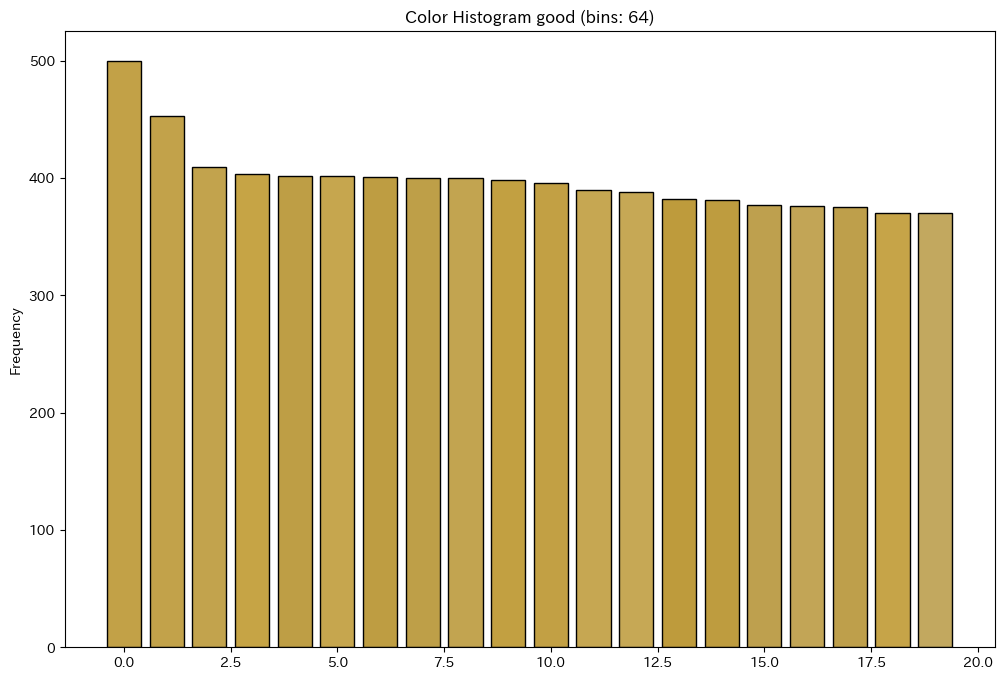

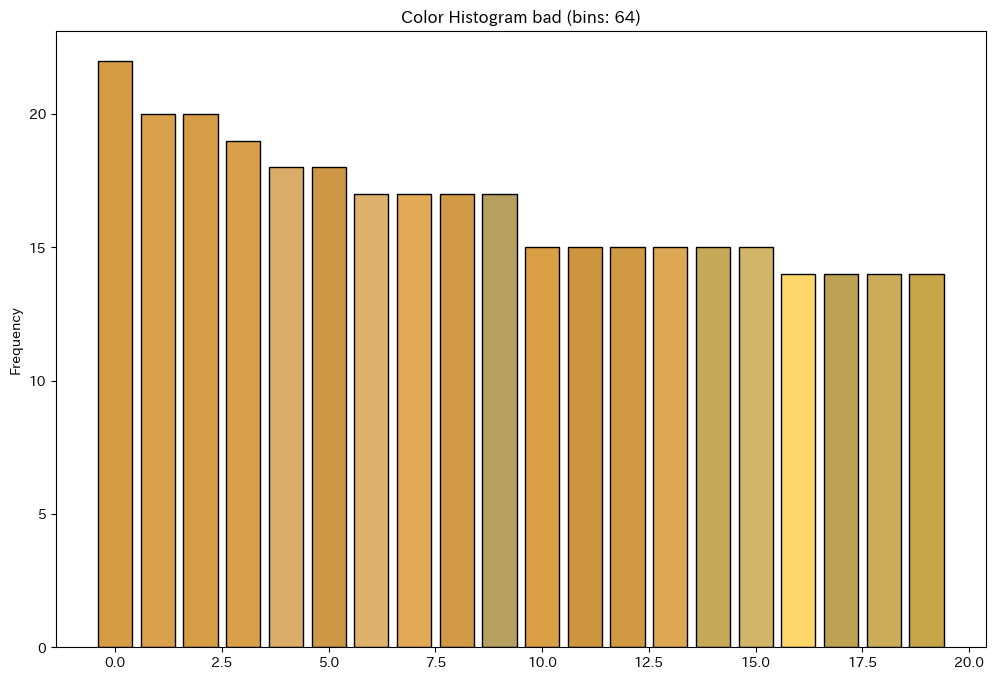

In [24]:
# -----------------------------------------------
# HSV
# -----------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

def quantize_colors(image, bins):
    bin_width = 256 // bins
    quantized_image = (image // bin_width) * bin_width + bin_width // 2
    return quantized_image

def calculate_color_histogram_hsv(images, bins):
    bin_width = 256 // bins
    hist = np.zeros((bins, bins, bins))
    for img in tqdm(images):
        hsv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        # Exclude black pixels (consider V channel)
        mask = hsv_image[..., 2] == 0
        non_black_pixels = hsv_image[~mask]
        
        quantized_image = quantize_colors(non_black_pixels, bins)
        h = quantized_image[..., 0] // bin_width
        s = quantized_image[..., 1] // bin_width
        v = quantized_image[..., 2] // bin_width
        for hi, si, vi in zip(h, s, v):
            hist[hi, si, vi] += 1
    return hist

def plot_color_histogram(hist, bins, name='good', num_colors=20):
    hist_flat = hist.flatten()
    colors = np.array([[h, s, v] for h in range(bins) for s in range(bins) for v in range(bins)])
    
    # Normalize histogram
    # hist_flat = hist_flat / hist_flat.sum()
    
    # Sort by frequency
    sorted_indices = np.argsort(hist_flat)[::-1]
    hist_flat = hist_flat[sorted_indices]
    colors = colors[sorted_indices]
    
    # Convert top colors back to RGB for plotting
    top_colors_hsv = colors[:num_colors] * (256 // bins) + (256 // bins // 2)
    top_colors_rgb = [cv2.cvtColor(np.uint8([[color]]), cv2.COLOR_HSV2RGB)[0][0] for color in top_colors_hsv]
    
    # Plot the histogram
    plt.figure(figsize=(12, 8))
    for i in range(min(len(hist_flat), num_colors)):  # Only show top num_colors
        plt.bar(i, hist_flat[i], color=top_colors_rgb[i] / 255, edgecolor='black')
    
    plt.title(f'Color Histogram {name} (bins: {bins})')
    plt.ylabel('Frequency')
    plt.savefig(f"color_histogram_{name}_bins{bins}.png", bbox_inches="tight")
    plt.show()

# Calculate color histograms in HSV
bins = 64  # Number of bins for each color channel
color_histogram_good_hsv = calculate_color_histogram_hsv(all_good_patches, bins)
color_histogram_bad_hsv = calculate_color_histogram_hsv(all_bad_patches, bins)

# Plot color histograms in HSV
plot_color_histogram(color_histogram_good_hsv, bins, name='good')
plot_color_histogram(color_histogram_bad_hsv, bins, name='bad')
